### Demonstration of Quantum Key Distribution

In this jupyter notebook we are going to demonstrate quantum key distribution using qiskit. By now, you should be familiar with the basic steps of the protocol. Just to recall shortly, the ultimate goal is to gain a _shared secret_. Bob and Alice will find a key, they can use for encrypting a message. Only they will be able to know this secret.

In [ ]:
import numpy as np

# Importing standard Qiskit libraries
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise  import NoiseModel
from numpy import pi

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

Alice will chose a basis and a bit randomly, Bob will pick a random basis. Thus we define a random measurement function. In other words a two sided dice:

In [ ]:
def random(circ, q, c):
    circ.reset(q) # we reset the qubit to |0>
    circ.h(q) # create superposition of |0> and |1>
    circ.measure(q,c) # measure: outcome will be 0 or 1, both 50% of the time
    circ.barrier() # this does not actually do anything

After this, Alice prepares the state for sending it to Bob

In [ ]:
def prepare(circ, q, cbit, cbasis):
    circ.reset(q) # reset the qubit
    circ.x(q).c_if(cbit, 0) # apply x-gate (NOT) if the classical bit cbit has value 0
    circ.h(q) # hadamard-gate on q
    circ.s(q).c_if(cbasis, 0) # conditioned s-gate if cbit has value 0
    circ.barrier() # again, nothing happens here

Finally, Bob will measure in the basis, he chose randomly in the step before.


<div class="alert alert-block alert-success">
<b>Exercise 1</b>
    
Darn! Bob does not remember how to implement the measurement process. Help him reconstruct his device, so he can communicate with Alice. Bob remembers, that the steps he has to take before measurement are the inverse of Alice's preparation process: $U_{Bob} = U_{Alice}^{\dagger} = (X H S)^{\dagger}$
    
</div>

In [ ]:
def measure(circ, q, cbit, cbasis):
    # your code goes here
    return

In [ ]:
# STEP 1: We initialize our registers. We use two qubits and four classical bits

alice = QuantumRegister(1, 'alice')
bob = QuantumRegister(1, 'bob')
abasis = ClassicalRegister(1, 'abasis')
abit = ClassicalRegister(1, 'abit')
bbasis = ClassicalRegister(1, 'bbasis')
bbit = ClassicalRegister(1, 'bbit')
qkd = QuantumCircuit(alice, bob, abasis, abit, bbasis, bbit)

# STEP 2: Alice chooses a basis randomly
random(qkd, alice[0], abasis[0])

# STEP 3: Alice chooses whether she sends 0 or 1 by random
random(qkd, alice[0], abit[0])

# STEP 4: Alice prepares the state for sending it to Bob
prepare(qkd, alice[0], abit[0], abasis[0])

# STEP 5: Bob chooses the basis for measurement and 'receives' the qubit from Alice via quantum channel
random(qkd, bob[0], bbasis[0])
qkd.swap(alice[0], bob[0])

# STEP 6: Finally, Bob performs the measurement, depending, on
measure(qkd, bob[0], bbit[0], bbasis[0])

qkd.draw()

Now Alice and Bob repeat their measurement process for 1024 times. We will simulate this by running our quantum algorithm in the Aer backend and extracting the bitstrings representing Alice and Bob's respective choices of basis (0 or 1 base) and their respective measurements.

In [ ]:
aer_sim = Aer.get_backend('aer_simulator') # we load the simulator backend

key_length = 1024 # let's create a 1024 bits long key

# these strings are gonna be the bitstrings representing Alice's and Bob's basis choices as well as their raw keys
abasis = "" 
abit = ""
bbasis = ""
bbit = ""

# run the algorithm 1024 times
for i in range(0, int(key_length)):
    results = aer_sim.run(qkd, shots=1).result()
    counts = results.get_counts()
    res = list(counts.keys())[0]
    abasis += res[6]
    abit += res[4]
    bbasis += res[2]
    bbit += res[0]


For example, Alice recovered this bitstring:

In [ ]:
abit

And Bob recovered this one:

In [ ]:
bbit

In [ ]:
abit == bbit

Note, that both bitstrings are **not** the same!

Next, we want to dwelve into the postprocessing. Of course, Alice and Bob sometimes accidentally pick a different basis and might thus measure a different outcome. This is the reason why at this point their keys do not match. Therefore, Bob and Alice have to compare their choices of basis and ignore all measurements in which they did not choose the same basis.

This process is called **key sifting** and is essential for the implementation of BB84. Without it, the whole protocol fails. 

<div class="alert alert-block alert-success">
<b>Exercise 2</b>
    
Your next task is to implement the key sifting. Basically, iterate over every single measurement and discard every bit for which the basis that Alice and Bob measured in does not match. The function 'sifted_key_positions' should return a list of all indeces of usable measurements.
    
</div>

In [ ]:
def sifted_key_positions(abasis, bbasis):
    pos = []
    for i in range(0, len(abasis)):
        # your code goes here
        pass
    return pos

In [ ]:
# now let's check whether Bob's key matches Alice's!

sifted_key_alice = "".join([abit[j] for j in sifted_key_positions(abasis, bbasis)])
sifted_key_bob = "".join([bbit[j] for j in sifted_key_positions(abasis, bbasis)])

sifted_key_alice == sifted_key_bob

In case this returns 'True': **BB84 was successfully implemented!** 

Congrats! But don't be too happy, since there is more work to be done. Unfortunately, _real life_ does not work like this.


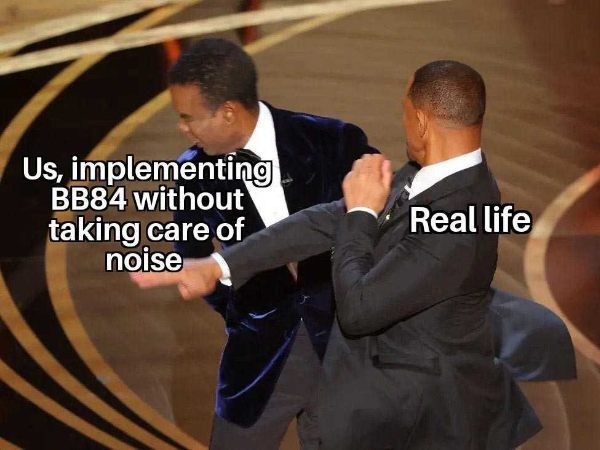

We will now introduce some noise to the quantum algorithm. Just recall for a moment, that every quantum mechanical system is prone to noise. For this, we can copy the noise from a _real_ machine.

In [ ]:
backend = provider.get_backend('ibmq_santiago')
aer_sim = AerSimulator.from_backend(backend)

key_length = 1024

abasis = ""
abit = ""
bbasis = ""
bbit = ""

for i in range(0, int(key_length)):
    results = qiskit.execute(qkd, aer_sim, shots=1).result()
    counts = results.get_counts()
    res = list(counts.keys())[0]
    abasis += res[6]
    abit += res[4]
    bbasis += res[2]
    bbit += res[0]
    
n_sifted_key_alice = "".join([abit[j] for j in sifted_key_positions(abasis, bbasis)])
n_sifted_key_bob = "".join([bbit[j] for j in sifted_key_positions(abasis, bbasis)])

print(n_sifted_key_alice == n_sifted_key_bob)

Nuts! Life sucks! Alice and Bob do not have the same key.

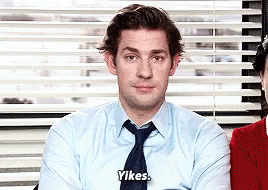

But how much exactly do they differ?

<div class="alert alert-block alert-success">
<b>Exercise 3</b>
    
Calculate the quantum bit error rate (QBER). It is defined as the rate of errors in the key. You can calculate it by counting the number of errors and then dividing by the key length.
    
</div>

In [ ]:
def qber(key_a, key_b):
    error_rate = 0
    # your code here
    return error_rate

In our case, this should be a little less than 7%. A complete implementation of the BB84 would also include an error correction algorithm. We're not gonna go there during this lecture. This is a problem computer scientists can think about, you don't have to worry about it _for now_.

Instead, since the whole point of quantum key distribution is to establish security, let's check what happens to our quantum system, in case there is an eavesdropper, Eve, trying to spy Alice and Bob's quantum conversation. We modify our quantum circuit a little:

In [ ]:
def eavesdropping(circ, q, qbasis, cbit, cbasis):
    random(qkd, qbasis, cbasis) # Eve will chose a basis for measuring the qubit randomly
    measure(qkd, q, cbit, cbasis) # next she measures it
    prepare(qkd, q, cbit, cbasis) # and then she prepares a new qubit so Bob will not be suspicious of her actions
    

# STEP 1: We initialize our registers. We use two qubits and four classical bits for Alice and Bob
# Add a qubit and two classical bits for Eve

alice = QuantumRegister(1, 'alice')
bob = QuantumRegister(1, 'bob')
eve = QuantumRegister(1, 'eve')

abasis = ClassicalRegister(1, 'abasis')
abit = ClassicalRegister(1, 'abit')
bbasis = ClassicalRegister(1, 'bbasis')
bbit = ClassicalRegister(1, 'bbit')
ebasis = ClassicalRegister(1, 'ebasis')
ebit = ClassicalRegister(1, 'ebit')

qkd = QuantumCircuit(alice, bob, eve, ebasis, ebit, abasis, abit, bbasis, bbit)

# STEP 2: Alice chooses a basis randomly
random(qkd, alice[0], abasis[0])

# STEP 3: Alice chooses whether she sends 0 or 1 by random
random(qkd, alice[0], abit[0])

# STEP 4: Alice prepares the state for sending it to Bob
prepare(qkd, alice[0], abit[0], abasis[0])

# STEP 5: Bob chooses the basis for measurement and 'receives' the qubit from Alice via quantum channel
random(qkd, bob[0], bbasis[0])

# STEP 5.5: Eve tries to get as much information as possible by intercepting every qubit, measuring it in a random basis
# and preparing a new qubit for Bob
eavesdropping(qkd, alice[0], eve[0], ebit[0], ebasis[0])

qkd.swap(alice[0], bob[0])

# STEP 6: Finally, Bob performs the measurement, depending, on
measure(qkd, bob[0], bbit[0], bbasis[0])

qkd.draw()

Great! Eve will read information from the quantum channel, but what happens now? Let's check it out. But for the sake of demonstration, we will remove any other noise - thus simulating an ideal system again.

In [ ]:
aer_sim = Aer.get_backend('aer_simulator') 

key_length = 2**11

abasis = ""
abit = ""
bbasis = ""
bbit = ""
ebasis = ""
ebit = ""

for i in range(0, int(key_length)):
    results = qiskit.execute(qkd, aer_sim, shots=1).result()
    counts = results.get_counts()
    res = list(counts.keys())[0]
    ebasis += res[10]
    ebit += res[8]
    abasis += res[6]
    abit += res[4]
    bbasis += res[2]
    bbit += res[0]

print(counts)

In [ ]:
ne_sifted_key_alice = "".join([abit[j] for j in sifted_key_positions(abasis, bbasis)])
ne_sifted_key_bob = "".join([bbit[j] for j in sifted_key_positions(abasis, bbasis)])

# Eve will have to stick with the basis choices of Alice and Bob
ne_sifted_key_eve = "".join([ebit[j] for j in sifted_key_positions(abasis, bbasis)])

print(f"Quantum bit error rate of Bob: {qber(ne_sifted_key_alice, ne_sifted_key_bob)*100:.2f}%")
print(f"Amount of information Eve was able to snoop on: {(1-qber(ne_sifted_key_alice, ne_sifted_key_eve))*100:.2f}%")

We observe that Eve was able to read a significant amount of the key! Actually she has about the same level of knowledge about Alice's numbers as Bob. This means a secure post-processing cannout be done. Alice and Bob should not use this quantum key! Fortunately, we also observe, that Bob's quantum bit error rate has increased to about 25%. This is another advantage of quantum key distribution: attacks can be noticed by Alice and Bob.

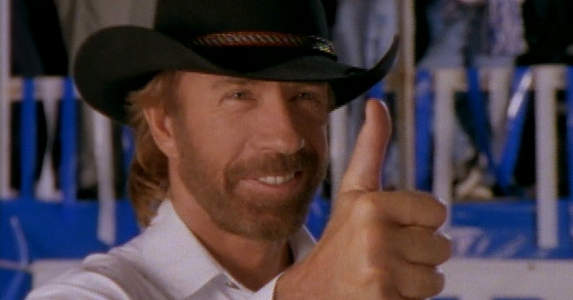

Congratulations! You have successfully completed the quantum key distribution demonstration in qiskit. We hope you had a fun ride and are looking forward to seeing you again soon!